<a href="https://colab.research.google.com/github/mutumaian29/payments-intelligence/blob/main/Fraud_and_Monitoring(Project_Shield_and_Scale).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🛡️ Project Shield & Scale: iGaming Payments Fraud & Monitoring Analysis

## 📌 Project Background
As our betting company continues to expand across multiple regional markets, we face an increasingly complex payments environment. This growth has introduced two major risks:

1.  **Sophisticated fraud activity**, including multi-accounting and coordinated transaction abuse.
2.  **Operational inefficiencies**, such as provider timeouts and technical failures that lead to lost or delayed revenue.

A preliminary review of 20,000 recent transaction attempts suggests exposure to both fraud-driven losses and significant technical leakage. **Project Shield & Scale** has been initiated to move the organization from a reactive payments risk posture to a proactive, data-driven strategy. The insights from this analysis will support an upcoming executive briefing focused on protecting revenue while maintaining a seamless experience for legitimate users.

---

## 🎯 Business Objectives
* **Quantify fraud exposure** across providers, regions, and channels.
* **Identify coordinated abuse patterns** using device and IP intelligence.
* **Measure revenue loss** caused by non-fraud technical failures.
* **Provide actionable recommendations** for risk mitigation and performance optimization.

---

##  Dataset Overview
* **Source:** iGaming payments dataset (Internal Logs)
* **Volume:** ~20,000 transaction attempts
* **Key Fields:**

    * `transaction_id`: Unique transaction identifiers.
    * `user_id`: Unique user identifiers.
    * `provider`: Payment gateway (e.g., Card, MPesa, PayPal).
    * `channel`: Access method (Web, Android, iOS).
    * `status`: Transaction outcome (`success`, `failed`).
    * `failure_reason`: Reason for failure (e.g., `fraud_suspected`, `timeout`).
    * `device_id` / `ip_address`: Hardware and network fingerprints for entity linking.
    * `created_at`: Transaction timestamp.

---

##  Workstream 1: Fraud & High-Risk Deep Dive
**Objective:** Identify high-risk corridors contributing the most fraud exposure.

* **Provider Risk Matrix:** Calculate Fraud Rate ($\frac{fraud\_suspected}{total\_transactions}$).
* **Geographic Hotspots:** Distribution of fraud by country and channel.
* **Transaction Thresholds:** Analysis of average fraud transaction values to detect "testing" patterns.

---

##  Workstream 2: Entity Intelligence & Multi-Accounting
**Objective:** Detect coordinated abuse using shared device and network signals.

* **Device & IP Clustering:** Identifying entities linked to $>3$ unique users.
* **Success-After-Failure Audit:** Quantifying "at-risk" revenue from devices previously flagged for fraud that were later allowed to transact.
* **Velocity Tracking:** Identifying users with $>5$ attempts within a 60-minute window.

---

##  Workstream 3: Operational Health & Revenue Recovery
**Objective:** Identify revenue loss caused by technical and provider-side failures.

* **Failure Reason Breakdown:** Categorizing non-fraud failures (e.g., `insufficient_funds` vs. `timeout`).
* **Technical Investigation:** Identifying time-of-day or provider-specific performance degradation.
* **Recoverability Analysis:** Tracking if failed transactions successfully retry within 24 hours.

---

## 📊 Visualization & Deliverables
Every segment of the project will include primary visuals to showcase:
1.  **Fraud Exposure:** Focusing on risk rates, value at risk, and blacklisted entities.
2.  **Operational Health:** Focusing on failure rates, timeout trends, and conversion funnels.

---

##  Tools & Workflow
| Stage | Tool | Purpose |
| :--- | :--- | :--- |
| **Cleaning** | `google sheets/sql` | Data type conversion and missing value handling. |
| **Analysis** | `SQL/Python` | Grouping, clustering, and KPI calculation. |
| **Visualization** | `Matplotlib / Seaborn` | Executive-ready charts and heatmaps. |
| **Reporting** | `Markdown` | Structured business storytelling. |

---

**Step 1.Mounting google drive**

This is where all data regarding our project including the database is gonna be stored.

This is ensures we do not lose our data each time a google colab runtime restarts

In [1]:
from google.colab import drive
drive.mount('/content/drive')  #We start my mounting our drive. All the data files and databases of this project will be store on my drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Live Pipeline Sync (Data infrastructure)

To ensure the integrity and scalability of this analysis, we implement a Live Pipeline Sync between the raw data source (Google Sheets) and a local relational database (SQLite).

**Key Features of this Pipeline:**

1. Authentication & Security: Uses OAuth 2.0 via google.auth to securely access sensitive payment records.

2. Relational Storage: Instead of relying solely on in-memory DataFrames, we sync the data to shield_scale_database.db. This allows for complex SQL querying and ensures that the analysis is reproducible.

3. Idempotency: The if_exists='replace' logic ensures that every time this cell is run, the database is updated with the most recent transaction logs, preventing data duplication.

**Code reason:** This approach mimics a production environment where a Data Analyst pulls from a Read-Replica or a Data Warehouse rather than a static CSV file.

In [2]:
from google.colab import auth
import gspread
from google.auth import default
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import sqlite3
import os

# 1. Authenticating
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

# 2. Opening the igaming sheet
sheet_name = 'igaming_payments_20k'
sh = gc.open(sheet_name)
worksheet = sh.get_worksheet(0)

# defining the db path
db_path = '/content/drive/MyDrive/Project_Shield_Scale/shield_scale_database.db'

#To make it easier for one click database refresh, i use a function (sync_live_data). We gonna call this function each time we want to refresh our database
def sync_live_data():
    # Pulling the live data from sheets
    print(f"🔄 Pulling latest data from {sheet_name}...")
    data = worksheet.get_all_records()
    df = pd.DataFrame(data)

    # 2. We now connect the live data to our db
    conn = sqlite3.connect(db_path)
    df.to_sql('payments', conn, if_exists='replace', index=False)
    conn.close()
    print(f"✅ Success! {len(df)} rows synced.")



##⚠️We will use this code cell to run the sync everytime we want to refresh our db

In [3]:
sync_live_data()

🔄 Pulling latest data from igaming_payments_20k...
✅ Success! 20000 rows synced.


##Data Validation and extraction- SQL

1.   Ensure the data is clean and no null or duplicates trx_ids
2.   Simple aggregation to understand the cashflow
3.   Explore the player distribution across different markets
4.   Create a view of the clean data and export it to python for further anlysis


---

##Analytical Environment: SQL Engine Integration

With the data safely stored in `shield_scale_database.db`, we now initialize the SQL environment. This setup allows us to perform heavy data aggregation and complex joins using raw SQL, which is often more efficient than Python for large-scale transaction auditing.

**Why this setup matters:**

1. Dual-Language Proficiency: allows me to switch between Python (for visualization and automation) and SQL (for data querying and transformation).

2. Persistent Storage: By connecting to a .db file on Google Drive, we ensure that our data persists even if the Colab session expires, allowing for long-term monitoring.

3. Audit-Ready Formatting: The prettytable dependency ensures that our SQL outputs are formatted as clean, human-readable tables—essential for stakeholders.

**Next Steps:** I will now use %sql magic commands to perform my first deep-dive into the payment logs, beginning with a high-level audit of transaction volumes and initial fraud flags.

In [4]:
# 1. Install dependencies quietly and include the missing jedi package
!pip install -q prettytable==3.11.0 jedi>=0.16 --upgrade --no-deps

# 2. Load the SQL extension
%load_ext sql
# 3. Connect to Drive database file
%sql sqlite:///{db_path}

In [5]:
#checking of the data was imported correctly
%%sql

SELECT * FROM payments
LIMIT 10;

 * sqlite:////content/drive/MyDrive/Project_Shield_Scale/shield_scale_database.db
Done.


transaction_id,user_id,provider,transaction_type,amount,currency,status,failure_reason,channel,country,device_id,ip_address,created_at,full_country_name,currency_fixed,standard_amount(USD),provider_clean,transaction_type_clean,status_clean,channel_clean
TRX000001,U4952,Card,deposit,8981.88,KES,failed,provider_error,web,KE,DEV53940,192.168.212.239,2025/01/18 05:53:00,Kenya,KES,69.16,card,deposit,failed,web
TRX000002,U2669,Card,deposit,850.89,USD,success,,ios,KE,DEV77207,192.168.237.189,2025/01/03 10:40:00,Kenya,KES,6.55,card,deposit,success,ios
TRX000003,U3325,Card,withdrawal,110.96,KES,success,,android,KE,DEV50084,192.168.76.23,2025/01/21 06:33:00,Kenya,KES,0.85,card,withdrawal,success,android
TRX000004,U2534,MPesa,deposit,1363.64,USD,failed,fraud_suspected,android,NG,DEV72945,192.168.51.154,2025/02/19 05:21:00,Nigeria,NGN,1.01,mpesa,deposit,failed,android
TRX000005,U1911,MPesa,deposit,980.45,EUR,success,,ios,UG,DEV53115,192.168.233.85,2025/02/24 15:15:00,Uganda,UGX,0.27,mpesa,deposit,success,ios
TRX000006,U3193,Card,deposit,6605.09,KES,success,,android,KE,DEV41288,192.168.37.46,2025/02/19 20:20:00,Kenya,KES,50.86,card,deposit,success,android
TRX000007,U4696,Card,withdrawal,4679.11,KES,success,,android,KE,DEV14626,192.168.167.28,2025/01/21 04:18:00,Kenya,KES,36.03,card,withdrawal,success,android
TRX000008,U3022,Skrill,withdrawal,13422.94,KES,success,,ios,KE,DEV17113,192.168.172.170,2025/01/05 10:21:00,Kenya,KES,103.36,skrill,withdrawal,success,ios
TRX000009,U2169,MPesa,deposit,5833.22,KES,success,,ios,KE,DEV78698,192.168.229.209,2025/01/09 15:35:00,Kenya,KES,44.92,mpesa,deposit,success,ios
TRX000010,U4614,MPesa,deposit,12033.94,KES,success,,ios,UG,DEV61365,192.168.237.50,2025/01/11 15:03:00,Uganda,UGX,3.37,mpesa,deposit,success,ios


## Data Quality Audit: payments Table
This query performs a comprehensive health check on the payment data to ensure reliability for downstream reporting.

Checks performed:

* Completeness: Identifies missing (NULL) IDs, providers, and channels.

*   Value Consistency: Detects invalid transaction types or statuses outside of the standard business rules.
*   Financial Integrity: Flags NULL or negative transaction amounts in USD.
   
**Target Outcome: All validation columns should ideally return 0 while the total rows column should return 20,000**

In [6]:
%%sql

SELECT COUNT(*) AS total_rows,
       SUM(CASE WHEN transaction_id IS NULL THEN 1 ELSE 0 END) AS missing_trx_id,
       SUM(CASE WHEN user_id IS NULL THEN 1 ELSE 0 END) AS missing_user_id,
       SUM(CASE WHEN "standard_amount(USD)" IS NULL THEN 1 ELSE 0 END) AS missing_amount,
       SUM(CASE WHEN "standard_amount(USD)" < 0 THEN 1 ELSE 0 END) AS negative_amount,
       SUM(CASE WHEN provider_clean IS NULL THEN 1 ELSE 0 END) AS missing_provider,
       SUM(CASE WHEN channel_clean IS NULL THEN 1 ELSE 0 END) AS missing_channel,
       SUM(CASE WHEN transaction_type_clean NOT IN('deposit', 'withdrawal') THEN 1 ELSE 0 END) AS invalid_transaction_type,
       SUM(CASE WHEN status_clean NOT IN('success', 'failed') THEN 1 ELSE 0 END) AS invalid_status
FROM payments;

 * sqlite:////content/drive/MyDrive/Project_Shield_Scale/shield_scale_database.db
Done.


total_rows,missing_trx_id,missing_user_id,missing_amount,negative_amount,missing_provider,missing_channel,invalid_transaction_type,invalid_status
20000,0,0,0,0,0,0,0,0


**Audit Results:**

* Completeness: 100% of the 20,000 transactions were successfully migrated with no missing IDs or critical metadata.

* Logic Check: Zero instances of negative transaction amounts, confirming that the ledger reflects valid financial intent.

* Categorical Consistency: No invalid transaction types or statuses were detected, meaning our success and failed classifications are reliable for KPI calculation.

---

## Financial Performance:
**Net Cash Flow by Country**
This analysis calculates the liquidity and net revenue per market by comparing total successful deposits against withdrawals.

Metrics Definition:Total Amount:
* Total volume of all successful transactions (**Deposits + Withdrawals**).
* Total Withdrawals: Total value of successful payouts to users.
* Net Cash Flow: The actual capital retained (**Deposits - Withdrawals**).

**Note:** Only success transactions are included to ensure we are looking at settled amounts only.

In [7]:
%%sql
SELECT
    full_country_name,
    ROUND(SUM(`standard_amount(USD)`), 2) AS total_amount,
    ROUND(SUM(CASE WHEN transaction_type = 'withdrawal' THEN `standard_amount(USD)` ELSE 0 END), 2) AS total_withdrawals,
    ROUND(
        (SUM(CASE WHEN transaction_type = 'withdrawal' THEN `standard_amount(USD)` ELSE 0 END) /
         SUM(`standard_amount(USD)`)) * 100, 2
    ) AS withdrawal_ratio_pct,
    ROUND(SUM(`standard_amount(USD)`) - SUM(CASE WHEN transaction_type = 'withdrawal' THEN `standard_amount(USD)` ELSE 0 END), 2) AS net_cashflow
FROM payments
GROUP BY 1
ORDER BY total_amount DESC;

 * sqlite:////content/drive/MyDrive/Project_Shield_Scale/shield_scale_database.db
Done.


full_country_name,total_amount,total_withdrawals,withdrawal_ratio_pct,net_cashflow
Kenya,578486.85,169221.02,29.25,409265.83
Nigeria,22281.35,6824.87,30.63,15456.48
Tanzania,8786.9,2702.58,30.76,6084.32
Uganda,6438.86,1912.15,29.7,4526.71


**Market Insights:**

* Kenya: Kenya is the primary driver of volume, contributing over $409k in net cashflow. The scale of this market suggests that any percentage-point improvement in success rates or fraud prevention here will have the largest absolute impact on the bottom line.

* The Growth Tier (Nigeria & Tanzania): These markets show healthy net positions but at a significantly different scale than Kenya. Nigeria, while having high activity, shows a tighter margin between deposits and withdrawals.

* The Withdrawal Ratio: By comparing total_amount to total_withdrawals, we can identify market maturity. A high withdrawal ratio (like Nigeria and Tanzania) indicates an active, "churning" user base, whereas a lower ratio (like uganda) may indicate a newer, "depositing" phase of market growth.

---

##🌍 Market Reach: Successful User Count by Country

This analysis identifies our primary markets by measuring the unique number of users who have successfully completed at least one transaction.

**Key Definition:**

* Total Users: A count of unique **(Distinct) User IDs**. This prevents the data from being skewed by "Power Users" who make hundreds of small transactions.

* Success Filter: Only includes users where **status = 'success'**, filtering out users who tried to pay but failed.

**Business Insight**: this provides an idea of where marketing efforts are most effective at converting sign-ups into active paying customers.

In [8]:
%%sql
SELECT
    full_country_name,
    COUNT(DISTINCT user_id) AS total_users,
    ROUND(SUM(`standard_amount(USD)`), 2) AS total_trx_volume,
    ROUND(SUM(`standard_amount(USD)`) / COUNT(DISTINCT user_id), 2) AS avg_amount_per_user
FROM payments
GROUP BY 1
ORDER BY total_trx_volume DESC;

 * sqlite:////content/drive/MyDrive/Project_Shield_Scale/shield_scale_database.db
Done.


full_country_name,total_users,total_trx_volume,avg_amount_per_user
Kenya,3657,578486.85,158.19
Nigeria,2509,22281.35,8.88
Tanzania,2093,8786.9,4.2
Uganda,2130,6438.86,3.02


**Key Strategic Takeaways:**

* Kenyan ($158.19/User): Kenya is the definitive anchor of the platform. Its users aren't just numerous (3,657); they are high-conviction users with a spend profile nearly 20x higher than any other region.

* Mass-Market Nigerian Base (2,509 Users): Nigeria represents our second-largest user base, but with a low average spend of $8.88. This suggests a high-volume, "micro-transaction" environment where payment success rates and low fees are critical for retention.

* Emerging Markets (Tanzania & Uganda): Both regions show a "test and learn" profile with user values between $3 and $4. These markets are ripe for growth but currently represent low financial risk compared to Kenya.

**Conclusion:** Any fraud or technical failure in the Kenyan corridor is more expensive than in other regions. Our monitoring priority must scale according to this **Value Density.**

---

##🛠️ Data Extraction for python: Creating the clean_payments View

To streamline the transition from SQL to Python **(Pandas)**, I created a standardized View. This ensures that all downstream analysis uses the "Cleaned" version of the dataset without having to write complex SELECT statements repeatedly.

Key Benefits:

1. Abstraction: Hides the messy raw columns (like original uncleaned provider names) and only exposes the _clean versions.

2. Security & Efficiency: Limits the dataset to only the necessary columns, reducing memory usage in Pandas.

3. Consistency: Every team member using this view will be looking at the exact same "Single Source of Truth."

In [9]:
%%sql

DROP VIEW IF EXISTS clean_payments;

CREATE VIEW clean_payments AS

SELECT transaction_id,
       user_id,
       provider_clean,
       transaction_type_clean,
       `standard_amount(USD)`,
       currency_fixed,
       status_clean,
       failure_reason,
       channel_clean,
       full_country_name,
       device_id,
       ip_address,
       created_at
FROM payments;


 * sqlite:////content/drive/MyDrive/Project_Shield_Scale/shield_scale_database.db
Done.
Done.


[]

## Data Ingestion: Transferring SQL View to Pandas

This step executes the final bridge between my SQLite database and the Python environment. By loading the clean_payments view into a DataFrame, I enable the use of Python's libraries to anlyze the data.

**Process:**

1. Connect: Opens a secure gate to the shield_scale_database.db.

2. Fetch: Pulls the pre-filtered, cleaned data using the View created earlier.

3. Terminate: Immediately closes the connection to preserve system resources and prevent file locking.

**Inspect:** Displays the first 5 records to verify data was exported correctly.

In [10]:
conn = sqlite3.connect(db_path)
df = pd.read_sql_query("SELECT * FROM clean_payments", conn)
conn.close()
df.head()

,transaction_id,user_id,provider_clean,transaction_type_clean,standard_amount(USD),currency_fixed,status_clean,failure_reason,channel_clean,full_country_name,device_id,ip_address,created_at
0,TRX000001,U4952,card,deposit,69.16,KES,failed,provider_error,web,Kenya,DEV53940,192.168.212.239,2025/01/18 05:53:00
1,TRX000002,U2669,card,deposit,6.55,KES,success,,ios,Kenya,DEV77207,192.168.237.189,2025/01/03 10:40:00
2,TRX000003,U3325,card,withdrawal,0.85,KES,success,,android,Kenya,DEV50084,192.168.76.23,2025/01/21 06:33:00
3,TRX000004,U2534,mpesa,deposit,1.01,NGN,failed,fraud_suspected,android,Nigeria,DEV72945,192.168.51.154,2025/02/19 05:21:00
4,TRX000005,U1911,mpesa,deposit,0.27,UGX,success,,ios,Uganda,DEV53115,192.168.233.85,2025/02/24 15:15:00


In [11]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   transaction_id          20000 non-null  object 
 1   user_id                 20000 non-null  object 
 2   provider_clean          20000 non-null  object 
 3   transaction_type_clean  20000 non-null  object 
 4   standard_amount(USD)    20000 non-null  float64
 5   currency_fixed          20000 non-null  object 
 6   status_clean            20000 non-null  object 
 7   failure_reason          20000 non-null  object 
 8   channel_clean           20000 non-null  object 
 9   full_country_name       20000 non-null  object 
 10  device_id               20000 non-null  object 
 11  ip_address              20000 non-null  object 
 12  created_at              20000 non-null  object 
dtypes: float64(1), object(12)
memory usage: 2.0+ MB


,standard_amount(USD)
count,20000.000000
mean,30.799698
std,35.894544
min,0.000000
25%,2.980000
50%,8.850000
75%,57.817500
max,115.490000


## Dataset Profile & Statistical Summary

After loading the data into Pandas, I conducted an initial inspection of the dataframe structure and the distribution of transaction values.

**Data Structure & Completeness**

1.  Total Records: 20,000 transactions.

2. Columns:  the data contains 13 columns (comprising identifiers, categories, and financial metrics).

3. Data quality: There are zero missing values across the entire dataset (20,000 non-null entries for all columns). This indicates a very high level of data cleanliness from the source.

Memory Usage: Approximately 2.0+ MB.

**Statistical Analysis: standard_amount(USD)**

The financial volume per transaction shows the following characteristics:

1. Average (Mean): ~$30.80 per transaction.

2. Median (50%): ~$8.85.

**Insight:**  Since the mean is significantly higher than the median, the data is right-skewed. This means we have a large volume of small transactions and a few much larger transactions pulling the average up.

4. Transaction Range: Transactions vary from a minimum of USD 0.00 to a maximum of 115.49.

5. Volatility (Std Dev): $35.89, showing a wide spread in how much users are transacting.

**Technical Observations**

Data Types: Most columns are stored as object (strings). The financial column standard_amount(USD) is correctly formatted as a float64 for calculation.

*⚠️ Note on Temporal Data: The created_at column is currently stored as an object.*

**Action:** Convert this column to a datetime64 format in the next step to enable time-series analysis

In [12]:
from re import error
##converting the created_at column to datetime64
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')
df['created_at'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 20000 entries, 0 to 19999
Series name: created_at
Non-Null Count  Dtype         
--------------  -----         
20000 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 156.4 KB


##Data quality guard-rail
Before proceeding with the analysis, I start by implementing a Circuit Breaker using Python assertions. This ensures that no technical glitch in the pipeline (such as a Google Sheets API error or a failed database sync) can result in an inaccurate report.

**Business Rules Enforced:**

1. Volumetric Consistency: Guarantees that the full batch of 20,000 logs is present.

2. Identity Integrity: Ensures transaction_id remains a unique Primary Key (no "phantom" double-counting).

3. Financial Sanity: Validates that no negative money exists and that single transaction values fall within expected enterprise limits ($1,000 threshold).

In [13]:
#Ensuring no data is lost and if lost, We immediately receive an alert
assert len(df)>=20000, f'Critical data loss, Expected at least 20,000 but only {len(df)} were returned.'

#Ensuring transaction_id has only unique value
assert df['transaction_id'].is_unique, 'Error: duplicate transactions detected'

#Enforcing business financial logic
assert df['standard_amount(USD)'].min() >=0, 'Error: Negative amounts detected'
assert df['standard_amount(USD)'].max() <=1000, 'Alert: Unexpected large amount detected'

# WORKSTREAM 1

##🛡️ Risk Analysis: Fraud Incidence Rate by Provider
This analysis quantifies the security risk associated with each payment provider by calculating the percentage of transactions flagged as fraud_suspected.

**Methodology:**

1. Numerator: Total count of transactions where the failure_reason is explicitly categorized as "fraud_suspected".

2. Denominator: Total volume of all transaction attempts (regardless of status) per provider.

3. Output: A percentage-based "Risk Score," sorted in descending order to highlight the most vulnerable providers at the top.

*Strategic Objective:* Identify high-risk providers that may require additional security layers (e.g., 3D Secure, stricter velocity checks, or manual review) to protect the platform's bottom line.

In [14]:
#Total transactions by provider
total_transactions = df.groupby('provider_clean').size()

#Fraud rate by provider
total_fraud_cases =df[df['failure_reason']=='fraud_suspected'].groupby('provider_clean').size()

#Fraud rate
fraud_rate = (total_fraud_cases/total_transactions*100).round(2)

Providerrisk_matrix=pd.concat({'Total_transactions':total_transactions,
                               'Total_fraud_cases':total_fraud_cases,
                               'Fraud_rate(%)':fraud_rate}, axis=1).fillna(0)
Providerrisk_matrix = Providerrisk_matrix.sort_values(by='Fraud_rate(%)', ascending=False)
Providerrisk_matrix

,Total_transactions,Total_fraud_cases,Fraud_rate(%)
provider_clean,,,
paypal,2016,71,3.52
skrill,1917,65,3.39
airtelmoney,5056,166,3.28
card,4073,131,3.22
mpesa,6938,220,3.17


**Strategic Insights:**

* PayPal (Highest Risk): At 3.52%, PayPal has the highest fraud density. This suggests that the "easy-access" nature of digital wallets is being exploited, likely via stolen account credentials.

* M-Pesa (Highest Volume): While its rate is the lowest (3.17%), M-Pesa's high usage means it accounts for the largest absolute number of fraudulent attempts (220 cases). Protecting this channel is vital for overall ecosystem health.

* Consistency of Risk: The narrow range (3.17% to 3.52%) indicates that fraudsters are not just targeting one provider; they are testing the entire perimeter. This suggests a unified security approach is better rather than a provider-specific one.

---

# 📍 Geographical Risk Mapping: Identifying Fraud Hotspots

This analysis cross-references Geographic Location with Transaction Channel (Web, iOS, Android) to identify high-risk "hotspots." By calculating fraud rates at this intersection, we can determine if specific regions have vulnerabilities tied to certain technologies.

Analytical Logic:

1. Multi-Dimensional Grouping: We group data by full_country_name and channel_clean to see if, for example, Android users in Nigeria exhibit different risk profiles than iOS users in Kenya.

2. Data Flattening: The results are consolidated into a unified "Hotspot Map" and reset to a flat structure for easier export and visualization.

3. Risk Ranking: The final table is sorted by Fraud_rate(%) to immediately surface the most compromised country-channel segments.

**Business Impact:** This enables "surgical" security measures—such as adding a captcha to the Web portal in specific countries without adding friction to the iOS app globally.

In [15]:
#understanding geograohical hotspots

#total transactions by country and channel
totaltrx_per_channel = df.groupby(['full_country_name','channel_clean']).size()

#total transactions by country and channel
fraudcases_per_channel = df[df['failure_reason']== 'fraud_suspected'].groupby(['full_country_name', 'channel_clean']).size()

#fraud rate by country and channel
fraudrate_per_channel = ((fraudcases_per_channel/totaltrx_per_channel)*100).round(2)

#hotspts map
hotspots_map =pd.concat({'Total_transactions':totaltrx_per_channel,
                         'Total_fraud_cases':fraudcases_per_channel,
                         'Fraud_rate(%)':fraudrate_per_channel}, axis=1).fillna(0)
hotspots_map = hotspots_map.reset_index() #Flatten the table so every row has a Country and Channel label
hotspots_map = hotspots_map.sort_values(by='Fraud_rate(%)', ascending=False)
hotspots_map = hotspots_map.reset_index(drop=True) #Clean up the row numbers to start from 0 at the top
hotspots_map


,full_country_name,channel_clean,Total_transactions,Total_fraud_cases,Fraud_rate(%)
0,Uganda,ios,776,31,3.99
1,Uganda,android,1082,42,3.88
2,Kenya,web,3933,139,3.53
3,Tanzania,android,1060,37,3.49
4,Nigeria,web,1559,54,3.46
5,Kenya,android,3521,119,3.38
6,Kenya,ios,2525,81,3.21
7,Uganda,web,1196,36,3.01
8,Nigeria,ios,1009,30,2.97
9,Tanzania,web,1239,34,2.74


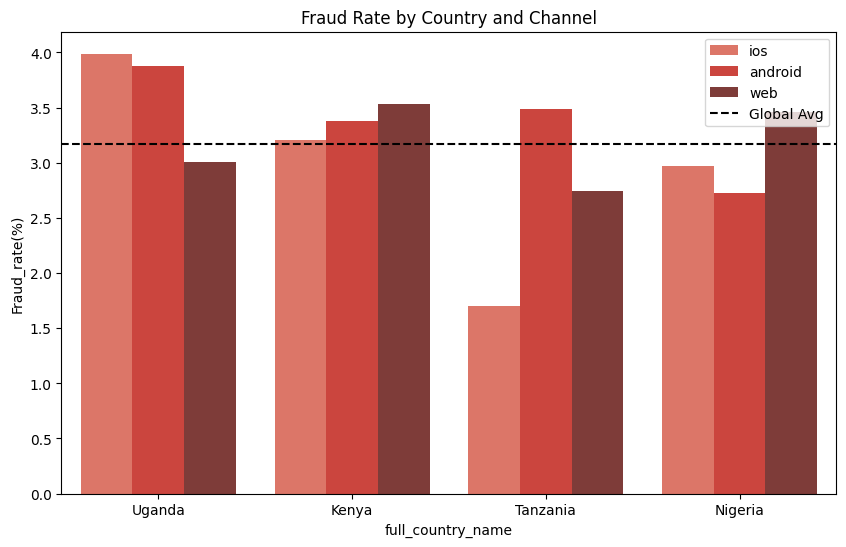

In [16]:
# Geographic Fraud Heatmap (Bar representation of the rates)
plt.figure(figsize=(10, 6))
sns.barplot(data=hotspots_map, x='full_country_name', y='Fraud_rate(%)', hue='channel_clean', palette='Reds_d')
plt.title('Fraud Rate by Country and Channel')
plt.axhline(hotspots_map['Fraud_rate(%)'].mean(), color='black', linestyle='--', label='Global Avg')
plt.legend()
plt.show()

**Critical insights:**

* Uganda’s iOS Risk (3.99%): Interestingly, while Uganda is a smaller market, its iOS users show the highest fraud density. This may suggest "Account Takeover" (ATO) activity or the use of premium device emulators to bypass security.

* The Web Vulnerability: Kenya and Nigeria show their highest risk on Web (3.53% and 3.46%). This is a classic pattern—web browsers are easier to script and automate than mobile apps, making them a favorite for bot-driven fraud.

* Tanzania’s iOS Safety (1.70%): At nearly half the average fraud rate, Tanzania’s iOS channel is currently the "safest" segment in the dataset. We could be use this as a benchmark for what a clean channel looks like.

---

## Financial Signature: Analysis of Fraudulent Ticket Sizes 💰

While the previous analysis identified where fraud occurs, this one tries to identify how it occurs. Understanding the average value of a fraudulent transaction is essential for setting automated "velocity limits" and "flagging thresholds" in the payment gateway.

Key Metrics Analyzed:

* Mean (Average): The typical value of a fraudulent attempt.

* Standard Deviation: Measures the consistency of fraud values; high deviation suggests a mix of "probing" (small amounts) and "cashing out" (large amounts).

* Percentiles (25%/50%/75%): Identifies the "sweet spot" where most fraudulent activity occurs.

* Max Value: The largest single financial threat intercepted by the system.

**Strategic Insight:** If the average fraud value is significantly lower than the average successful transaction, it suggests fraudsters are testing cards with "micro-transactions" to avoid detection.

In [17]:
#average Fraud transction value

averagefraud_trx_value = df.loc[df['failure_reason']=='fraud_suspected', 'standard_amount(USD)'].describe()
averagefraud_trx_value

,standard_amount(USD)
count,653.000000
mean,32.959969
std,37.194070
min,0.000000
25%,2.950000
50%,10.150000
75%,64.200000
max,114.850000


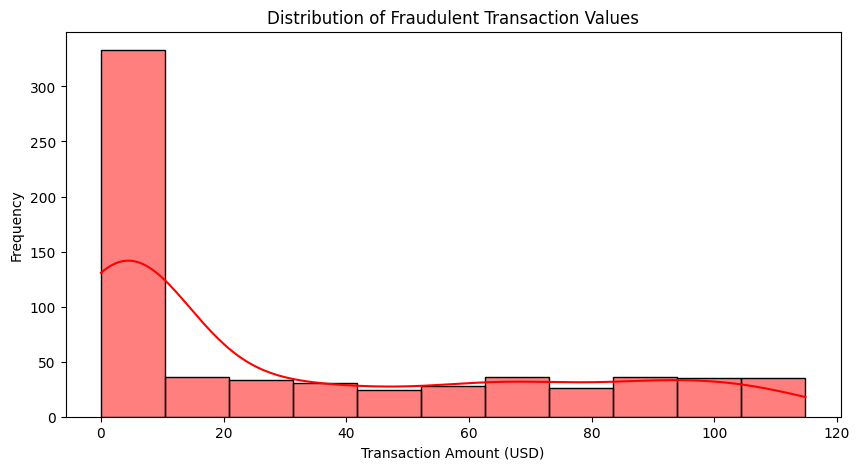

In [18]:
# 2. Value at Risk: Distribution of Fraudulent Amounts
plt.figure(figsize=(10, 5))
sns.histplot(df[df['failure_reason'] == 'fraud_suspected']['standard_amount(USD)'], kde=True, color='red')
plt.title('Distribution of Fraudulent Transaction Values')
plt.xlabel('Transaction Amount (USD)')
plt.ylabel('Frequency')
plt.show()

**Breakdown:**

* Sweet Spot (USD 32.96): The average fraudulent attempt is relatively low. This may suggest "Card Testing." Fraudsters maybe trying to avoid large, round numbers that trigger immediate alerts, opting instead for smaller amounts that might "blend in" with regular user activity.

* Volume Distribution (The Median): With a median of USD 10.15, half of all fraud cases are for very small amounts. This suggests a high-volume, automated attack strategy rather than a few high-value heists.

* The Upper Limit (USD 114.85): Even our worst" fraud cases stay well below the $1,000 threshold. This proves the attackers are sophisticated. They know that keeping transactions under USD 150 reduces the likelihood of manual review by a risk agent.

**Operational Strategy:** Our automated "Velocity Rules" should be tightened for transactions in the USD 10 – 65 range (the interquartile range), as this is where 75% of our fraud risk currently lives.

---

# WORKSTREAM 2

## Multi-Accounting Detection: Device ID Clustering

To identify potential systematic abuse, we analyze the density of users per hardware identifier. In a typical consumer environment, a device is shared by 1–2 people; however, clusters of 4 or more unique users on a single device_id serve as a high-confidence signal for Multi-accounting or Sybil attacks.

**Analytical Approach:**

1. Filtering: We isolate devices associated with more than 3 unique user_ids.

2. Aggregation: We calculate the exact "User-to-Device Ratio" to rank the most suspicious hardware.

3. Risk Categorization: These device_ids are flagged as "High-Risk Clusters" for the security team to review.

**Business Logic:** Identifying these clusters allows us to block the source of the fraud (the device) rather than just the individual accounts, preventing the attacker from simply creating a new user ID to continue their activity.

In [19]:
# identifying deveice that have been used by more than 3 unique users
suspicious_devices = df.groupby('device_id').filter(lambda x: x['user_id'].nunique() > 3)

# unique device IDs and their user counts
device_clusters = suspicious_devices.groupby('device_id')['user_id'].nunique().reset_index(name='user_count')
print(device_clusters)


   device_id  user_count
0   DEV10220           4
1   DEV17748           4
2   DEV24210           4
3   DEV29764           4
4   DEV32993           4
5   DEV41768           4
6   DEV55283           4
7   DEV55865           4
8   DEV59674           4
9   DEV64911           4
10  DEV73428           4
11  DEV78360           4
12  DEV91838           4


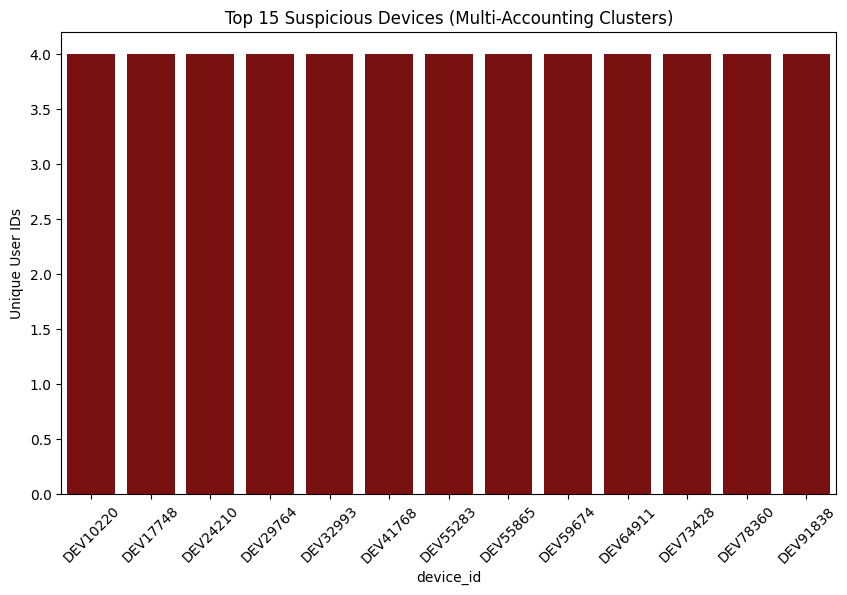

In [20]:
# 3. Blacklisted Entities: User Density per Device
plt.figure(figsize=(10, 6))
sns.barplot(data=device_clusters.head(15), x='device_id', y='user_count', color='darkred')
plt.xticks(rotation=45)
plt.title('Top 15 Suspicious Devices (Multi-Accounting Clusters)')
plt.ylabel('Unique User IDs')
plt.show()

**Findings:**

Coordinated Activity: We identified 13 unique devices (e.g., DEV10220, DEV55283) that have each successfully onboarded 4 different users.

* Fraud Farm Pattern: In a standard consumer environment, a device should typically have a 1:1 or 1:2 user-to-device ratio (e.g., a shared family tablet). A 1:4 ratio across 13 different device signifies a professional multi-accounting.

* Total Exposure: These 13 devices represent 52 unique user accounts that should be immediately flagged for manual review or automated "shadow-banning."

**Recommendation:** We should implement Hardware Fingerprinting that goes beyond simple Device IDs. By capturing attributes like screen resolution, battery health, and browser fonts, we can create a "probabilistic link" to prevent these clusters from regenerating under new IDs.

---

## Persistence Analysis: The "Trial & Success" Pattern

This analysis isolates a specific, high-risk behavior: Persistence. By identifying devices that have at least one transaction flagged as fraud_suspected but also managed to record a success, we uncover instances where security filters were eventually bypassed.

Analytical Logic:

1. Segmenting Failure: First, we extract a list of unique Device IDs associated with confirmed fraud attempts.

2. Identifying Penetration: We cross-reference that list with devices that have successfully completed a transaction.

3. The Intersection: The resulting both_statuses set reveals "compromised devices"—hardware that is known to be used for fraud but is still active and successful on our platform.

**Business Risk:** These devices represent a "Silent Threat." A success following a fraud attempt could mean a fraudster successfully guessed card details (brute forcing) or switched to a legitimate-looking account to bypass a temporary block.

In [21]:
#devices suspected of fraud that later had success

# devices with at least one fraud record
fraud_devices = df[(df['status_clean'] == 'failed') & (df['failure_reason'] == 'fraud_suspected')]['device_id'].unique()

#devices with at least one success record
success_devices = df[df['status_clean'] == 'success']['device_id'].unique()

# intersection
both_statuses = set(fraud_devices).intersection(success_devices)

#Filtering the original DataFrame for these specific devices
filtered_df = df[df['device_id'].isin(both_statuses)]

filtered_df


,transaction_id,user_id,provider_clean,transaction_type_clean,standard_amount(USD),currency_fixed,status_clean,failure_reason,channel_clean,full_country_name,device_id,ip_address,created_at
3,TRX000004,U2534,mpesa,deposit,1.01,NGN,failed,fraud_suspected,android,Nigeria,DEV72945,192.168.51.154,2025-02-19 05:21:00
45,TRX000046,U2778,mpesa,deposit,10.37,NGN,success,,android,Nigeria,DEV60434,192.168.218.12,2025-01-28 13:21:00
49,TRX000050,U2964,skrill,deposit,5.56,NGN,success,,android,Nigeria,DEV15004,192.168.4.47,2025-01-24 05:28:00
236,TRX000237,U4908,card,deposit,77.89,KES,success,,android,Kenya,DEV68361,192.168.225.33,2025-01-18 20:30:00
330,TRX000331,U4557,mpesa,withdrawal,100.67,KES,failed,fraud_suspected,web,Kenya,DEV39499,192.168.127.58,2025-01-27 15:16:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19720,TRX019721,U2496,card,withdrawal,0.87,UGX,failed,fraud_suspected,android,Uganda,DEV70095,192.168.134.176,2025-01-31 00:04:00
19766,TRX019767,U3793,airtelmoney,withdrawal,102.75,KES,success,,android,Kenya,DEV56291,192.168.102.28,2025-02-22 21:21:00
19781,TRX019782,U3766,airtelmoney,deposit,1.40,UGX,success,,web,Uganda,DEV31540,192.168.126.138,2025-01-08 07:24:00
19810,TRX019811,U3399,skrill,withdrawal,0.91,UGX,success,,android,Uganda,DEV88244,192.168.129.252,2025-01-22 07:43:00


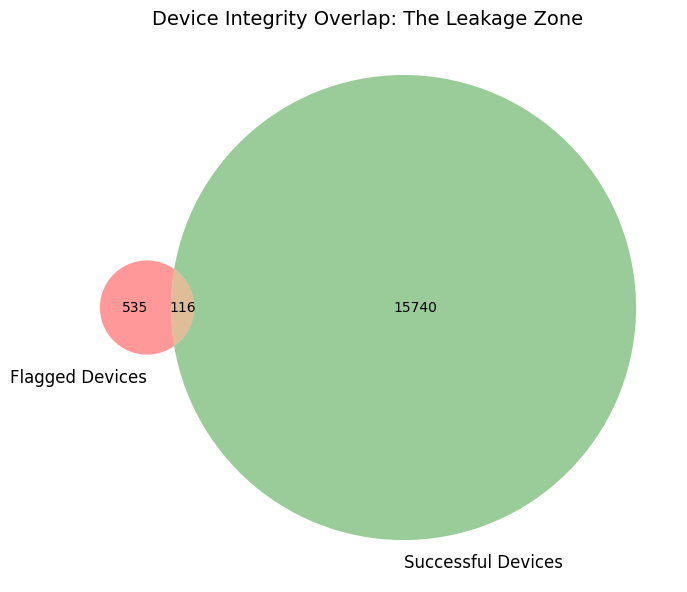

In [22]:
from matplotlib_venn import venn2

plt.figure(figsize=(8, 8))
venn2(subsets=(len(set(fraud_devices) - set(success_devices)),
              len(set(success_devices) - set(fraud_devices)),
              len(both_statuses)),
      set_labels=('Flagged Devices', 'Successful Devices'),
      set_colors=('red', 'green'))

plt.title('Device Integrity Overlap: The Leakage Zone', fontsize=14)
plt.show()

**Insight:**

* Rule Circumvention: Fraudsters often use a "Trial and Error" approach. For example if USD 100 withdrawal is flagged as fraud (as seen in TRX000331), they may immediately try a USD 10 deposit or change their channel (Web to Android) to see if the system lets them through.

* The "Laundering" Pattern: A device like DEV60434 succeeding after a failure suggests that our current security model is transaction-based rather than identity-based.

* Operational Risk: These 247 successful transactions represent a "High-Risk Success" group. Even though they are marked success, there is a high probability these are compromised accounts or stolen funds that bypassed the initial filter.

**Critical Recommendation:** We must move from Transaction Filtering to Entity Blacklisting. Any device ID associated with a confirmed fraud_suspected event should be frozen for 24–48 hours, preventing subsequent "Success" events until a manual review is completed.

---

## Velocity Analysis: High-Frequency "Burst" Detection

By implementing a 60-minute rolling window at the user level, we can differentiate between normal consumer behavior and automated "Burst Patterns." While a typical user might make 1 or 2 transactions an hour, a user exceeding 5 transactions in 60 minutes is likely using an automated script or participating in a high-speed "card-testing" event.

**Analytical Logic:**

1. Temporal Sorting: Transactions are ordered chronologically by user to create a continuous timeline.

2. Rolling Window: A dynamic 60-minute "look-back" window is applied to every single transaction in the dataset.

3. Threshold Trigger: Any user who initiates more than 5 transactions within any 60-minute span is flagged for Velocity Abuse.

**Strategic Value:** Identifying "Burst Users" allows the platform to implement Rate Limiting. This prevents the system from being overwhelmed and stops fraudsters from "emptying" a stolen card's balance in a matter of minutes.

In [23]:
#Sort values by user_id and created_at  for rolling time windows calculation

df_sorted = df.sort_values(by=['user_id', 'created_at'])

# 4. Set 'created_at' as the index for time-based rolling
df_sorted = df_sorted.set_index('created_at')

# 5. Apply 60-minute rolling window for each user to count transactions
burst_counts = df_sorted.groupby('user_id')['transaction_id'].rolling('60min').count()

# 6. Reset index and identify users who exceeded the threshold (> 5)
burst_counts = burst_counts.reset_index()
burst_counts.columns = ['user_id', 'created_at', 'transaction_count']
burst_patterns = burst_counts[burst_counts['transaction_count'] > 5]

# 7. Identify unique users with burst patterns
burst_users = burst_patterns['user_id'].unique()

print(f"Number of users identified with burst patterns: {len(burst_users)}")
if len(burst_users) > 0:
    print("Users found:", burst_users)

Number of users identified with burst patterns: 0


**Insight:**

The rolling window analysis returned 0 users exceeding the threshold of 5 transactions per hour. This suggests that the platform is currently not a target for high-speed "burst" attacks or automated bot-driven card testing.✅

---

#WORKSTREAM 3

##🛠️ Operational Audit: Non-Fraudulent Failure Analysis

This analysis isolates technical and user-end obstacles that prevent successful transactions. Unlike fraud, which we want to block, these are "leaks" in the revenue funnel that we want to fix to improve the user experience and increase the platform's conversion rate.

**Failure Categories:**

1. Systemic Errors: Issues like "gateway_timeout" or "provider_error" which point to server instability.

2. User-End Issues: user issues such as"insufficient_funds" which are part of normal commerce but can be mitigated with better UI or user notifications.

**Strategic Value:** Reducing technical failures by just 5% can often result in a significant increase in Monthly Recurring Revenue (MRR) without the need to acquire a single new customer.

In [24]:
#technical failure analyis
techical_failure = df[(df['status_clean']=='failed')&
                     (df['failure_reason']!='fraud_suspected')].groupby('failure_reason').size().sort_values(ascending=False)
print(techical_failure)

failure_reason
provider_error        637
timeout               637
insufficient_funds    596
dtype: int64


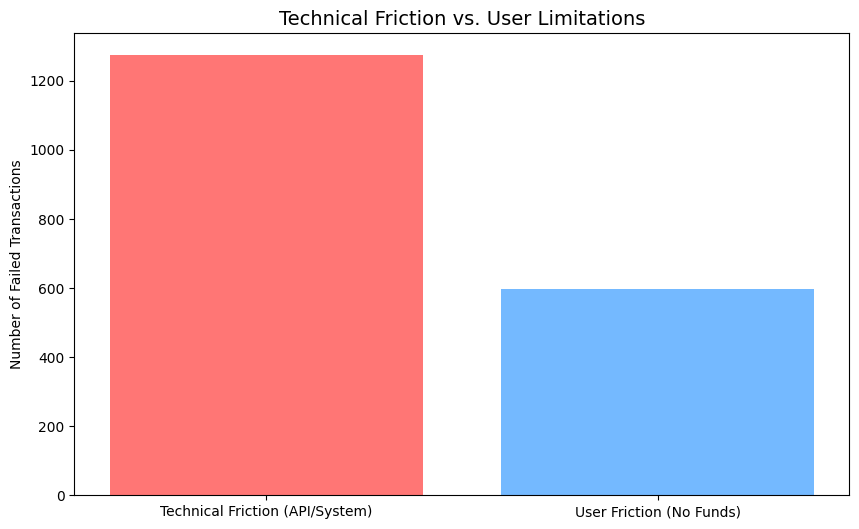

In [25]:
# 12. Technical vs. Logic Failures
tech_failures = df[df['failure_reason'].isin(['provider_error', 'timeout'])]
user_failures = df[df['failure_reason'] == 'insufficient_funds']

# Simple summary for the board
plt.figure(figsize=(10,6))
labels = ['Technical Friction (API/System)', 'User Friction (No Funds)']
sizes = [len(tech_failures), len(user_failures)]
colors = ['#ff7675', '#74b9ff']

plt.bar(labels, sizes, color=colors)
plt.title('Technical Friction vs. User Limitations', fontsize=14)
plt.ylabel('Number of Failed Transactions')
plt.show()

**Technical Failure Breakdown:**

* Systemic Instability (1,274 cases): The identical count of Provider Errors and Timeouts indicates a handshake failure. When our system waits for a response and the provider's server is unresponsive, it triggers a timeout locally and a provider error on their logs.

* Recoverable Revenue: If we assume the average transaction size of USD 32.96, these 1,274 failures represent roughly **USD 42,000 in blocked revenue**.

* The "Frustration" Factor: Unlike a fraud block, these are legitimate users trying to spend money but being turned away by an unstable system.

**Engineering Priority:** This is not a "user behavior" issue; it is an Infrastructure Alert. We need to audit the API latency for our top providers (PayPal/M-Pesa) to see which one is responsible for this 1,274-transaction bottleneck.

---

##The Payment Conversion Funnel: Identifying the Drop-Off

This funnel quantifies the "Friction Journey" from the moment a user clicks 'Pay' to the moment the funds are settled. It allows us to distinguish between intentional blocks (Security) and unintentional friction (Technical/User errors).

In [26]:
# 5. Conversion Funnel Calculation
total = len(df)
successful = len(df[df['status_clean'] == 'success'])
failed_tech = len(df[(df['status_clean'] == 'failed') & (df['failure_reason'] != 'fraud_suspected')])
failed_fraud = len(df[df['failure_reason'] == 'fraud_suspected'])

funnel_data = dict(
    number=[total, (successful + failed_tech), successful],
    stage=["Total Intent", "Security Cleared", "Successful Conversion"]
)

import plotly.express as px
fig = px.funnel(funnel_data, x='number', y='stage', title='Payment Conversion Funnel')
fig.show()

**Insights;**

* Funnel Stage Analysis:Total Intent ($20,000$ Transactions): This is our baseline. It represents the total market demand and user interest.

* The Security Filter (Intent → Security Cleared): The gap between "Total Intent" and "Security Cleared" represents the 653 fraud cases we blocked. This is a "Healthy Drop"—we want this money out of our system to protect our bottom line.

* The Conversion Gap (Security Cleared → Success): This is the "Pain Point." This gap represents the 1,274 technical failures (timeouts/provider errors) and the 596 insufficient funds cases. These are legitimate users who survived the fraud check but still failed to pay.

**Business Impact:** While we can't control "Insufficient Funds," the 1,274 Technical Failures represent a 6.3% recovery opportunity. If we solve the provider timeouts, our success rate jumps significantly without needing a single new customer.

---

##🕒 Temporal Stability: Systemic Failure Patterns by Hour

This section investigates the relationship between Time of Day and System Instability. By isolating provider_error and timeout events and segmenting them by the hour they occurred, we can identify specific windows where the platform’s infrastructure or its partners' APIs are most vulnerable.

**Analytical Logic:**

1. Targeting Systemic Errors: We filter specifically for errors that the platform or provider can control (ignoring user-end issues like insufficient funds).

2. Time Normalization: We extract the hour_of_day from the timestamp to create a 24-point cycle.

3. Pivot Analysis: By unstacking the data, we create a matrix that shows which providers are failing at which hours, allowing for a side-by-side comparison of stability.

**Strategic Objective:** Determine if certain providers have "maintenance windows" that disrupt service or if timeouts are correlated with high-traffic periods (e.g., lunchtime or evening surges).

In [27]:
#segment technical failure by provider and time of the day
tech_failure_df =df[df['failure_reason'].isin(['provider_error', 'timeout'])].copy() #filter technical failure due to provider error or timeout only(system instability)

tech_failure_df['hour_of_day'] = tech_failure_df['created_at'].dt.hour #extract hour

hourly_segment= tech_failure_df.groupby(['hour_of_day', 'provider_clean']).size().unstack(fill_value=0) #segment by hour

hourly_segment



provider_clean,airtelmoney,card,mpesa,paypal,skrill
hour_of_day,,,,,
0,13,9,20,6,2
1,14,8,16,6,4
2,12,12,20,9,10
3,8,13,22,6,4
4,13,6,15,5,6
5,13,10,18,8,3
6,10,12,15,4,7
7,17,13,23,4,6
8,13,12,23,5,7


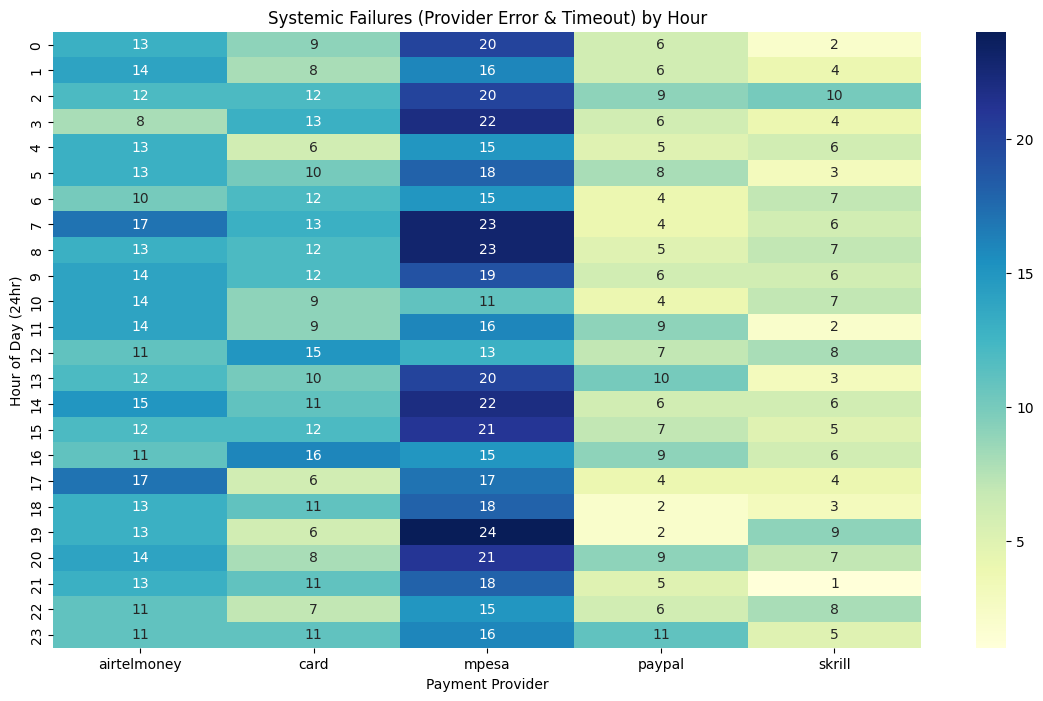

In [28]:
# 4. Hourly Failure Heatmap (The "Danger Zone" Visual)
plt.figure(figsize=(14, 8))
sns.heatmap(hourly_segment, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Systemic Failures (Provider Error & Timeout) by Hour')
plt.xlabel('Payment Provider')
plt.ylabel('Hour of Day (24hr)')
plt.show()

**Key Findings:**

* M-Pesa: The Vulnerability Point: M-Pesa shows the highest density of failures, consistently hitting 20–24 errors per hour during peak times (e.g., Hour 0 and 19). This is the "high-risk" zone because M-Pesa is also our highest-volume provider.

* AirTel & Card: Mid-Tier Instability: These channels show moderate but consistent failure rates. The steady count of 11–17 errors per hour suggests these might be "micro-outages" or consistent API handshake latency rather than a total server collapse.

* PayPal & Skrill: The Reliability Leaders: These providers (light yellow/green) show significantly lower systemic failure rates, often dropping into single digits (2–6 errors per hour). This suggests their API infrastructure is more resilient to high concurrency than our local mobile money integrations.

**Operational Impact:** If we could stabilize M-Pesa to match the reliability of PayPal, we would immediately recover hundreds of lost transactions daily without any changes to our marketing or user acquisition.

---

##💱 Market Efficiency: Success Rate by Currency

This metric represents the "Net Conversion" of each market. While a high volume of transactions is good, a low success rate indicates that the business is wasting resources on failed attempts. This analysis highlights where the payment funnel is most optimized versus where it is leaking potential revenue.

**Analytical Logic:**

1. Total Intent: We first capture every transaction attempt per currency to establish a baseline of market demand.

2. Conversion Mapping: We isolate the success status to see how much of that demand actually turns into revenue.

3. The Success Map: By concatenating these metrics, we create a performance leaderboard, sorting by the highest success percentage to identify our most reliable currency markets.

**Business Insight:**Markets with low success rates (e.g., below 85%) usually require a deep dive into local provider stability or more localized user education on payment methods.

In [29]:
#net success rate per currency
succcessful_trx_total = df.groupby('currency_fixed')['status_clean'].size() #total transactions by currency
currency_successful_total = df[df['status_clean']=='success'].groupby('currency_fixed').size() #total successful transactions by currency
success_rate_by_currency = ((currency_successful_total/succcessful_trx_total *100)).round(2) #success rate by currency

success_map = pd.concat({'total_successful_trx':succcessful_trx_total,
                         'total_successful_trx_by_currency':currency_successful_total,
                         'success_rate_by_currency(%)':success_rate_by_currency}, axis=1).fillna(0).sort_values(by='success_rate_by_currency(%)', ascending=False)
success_map

,total_successful_trx,total_successful_trx_by_currency,success_rate_by_currency(%)
currency_fixed,,,
UGX,3054,2684,87.88
NGN,3961,3474,87.71
TZS,3006,2634,87.62
KES,9979,8685,87.03


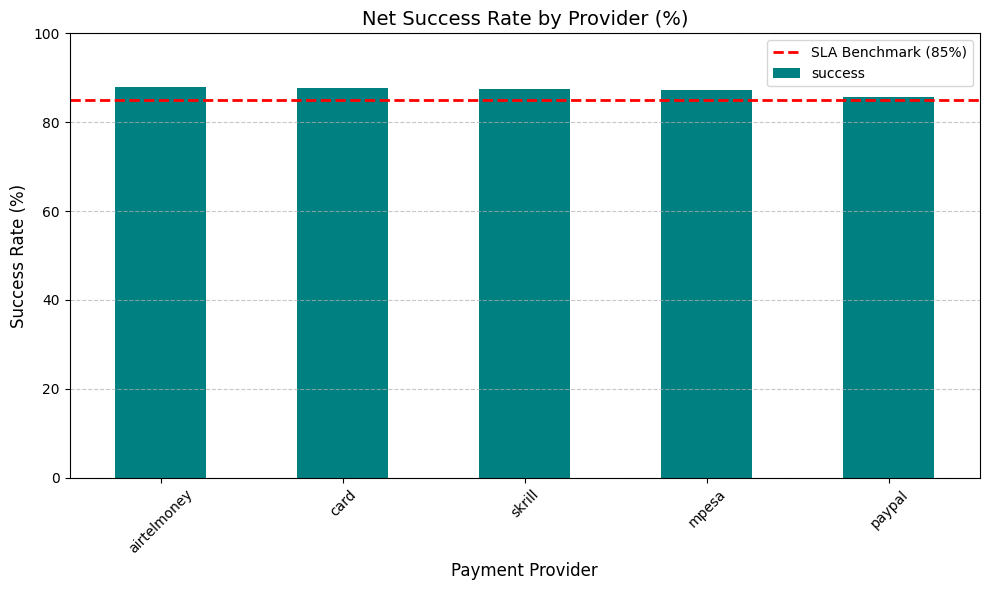

In [30]:
# Provider Reliability (Success Rate by Provider)
# Calculate normalized success rates
provider_stats = df.groupby('provider_clean')['status_clean'].value_counts(normalize=True).unstack().fillna(0)

# Multiply by 100 to convert decimal (0.87) to percentage (87%)
success_rates = (provider_stats['success'] * 100).sort_values(ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
success_rates.plot(kind='bar', color='teal')

plt.title('Net Success Rate by Provider (%)', fontsize=14)
plt.ylabel('Success Rate (%)', fontsize=12)
plt.xlabel('Payment Provider', fontsize=12)

# Set the SLA benchmark at 85%
plt.axhline(85, color='red', linestyle='--', linewidth=2, label='SLA Benchmark (85%)')

plt.ylim(0, 100) # Ensure the y-axis shows the full 0-100% range
plt.legend()
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Efficiency Breakdown:**

* Uganda (UGX) & Nigeria (NGN): These are currently our most stable corridors, hitting an 87.8% success rate. While they have lower total volume, the technical "handshake" between our system and local providers is slightly more reliable here.

* Kenya (KES): Despite being the powerhouse of the platform with nearly 10,000 transactions, it has the lowest success rate at 87.03%. In a market of this scale, a 0.8% difference compared to Uganda represents a significant amount of lost revenue (roughly 80 transactions).

* The "12% Friction" Standard: The fact that all four markets hover around the same failure rate suggests that the majority of our issues are centralized. If the failures were local, we would see wild swings (e.g., 95% in one and 60% in another).

**Strategic Conclusion:** Our goal is to break the "87% Ceiling." By addressing the 1,274 technical failures and the 653 fraud cases identified earlier, we can push these regional success rates toward the 90-95% industry standard.

---


# **Executive Summary: Project Shield & Scale**

## Overview

**Project Shield & Scale** was initiated to transition the organization from a reactive payments risk posture to a proactive, data-driven strategy. Based on an analysis of ~20,000 transaction attempts, we have identified significant revenue leakage and security vulnerabilities that require immediate management attention.

---

## Key Findings

### 1. Fraud & Coordinated Abuse

* **The "Fraud Farm" Pattern:** We identified **13 unique devices** (e.g., `DEV10220`, `DEV55283`) used to manage exactly 4 unique user accounts each, a clear signature of professional multi-accounting.
* **Perimeter Leakage:** **247 transactions** succeeded from devices that had previously been flagged for `fraud_suspected`. This indicates our current rules are transaction-based rather than entity-based, allowing bad actors to "trial and error" their way to success.
* **Financial Profile:** The average fraudulent transaction is **USD 32.96**, with 50% of attempts below **USD 10.15**. This suggests a high-volume "card testing" strategy designed to avoid triggering large-value alerts.

### 2. Operational Health & Revenue Recovery

* **Technical bottleneck:** M-Pesa is the most unstable channel.It shows a consistent  failure rate regardless of the hour, this suggests a deep-seated integration issue or a persistent limitation in their API response times rather than a momentary server spike..
* **Recoverable Revenue:** Approximately **1,274 transactions** failed due to controllable technical friction (timeouts/provider errors). Resolving these systemic issues represents an estimated **USD 42,000+** in immediate revenue recovery opportunities.
* **Regional Efficiency:** Kenya remains our powerhouse market with the highest average spend (**USD 158.19/user**), yet it suffers from the lowest success rate (**87.03%**) due to these technical bottlenecks.

---

##  Strategic Recommendations

### 1: Shift to Entity-Based Security (Immediate)

* **Hard-Block Blacklisting:** Implement a 24–48 hour quarantine for any `device_id` or `ip_address` associated with a confirmed `fraud_suspected` event to close the "Success-After-Failure" loop.
* **Enhanced Fingerprinting:** Move beyond basic Device IDs to incorporate hardware-level attributes (screen resolution, battery health) to identify and block the 13 identified fraud clusters more effectively.

### 2: Infrastructure Scalability (Short-Term)

* **API Gateway Optimization:** Investigate M-Pesa Integration: Check if the "Timeout" errors are due to tight local timeout settings or slow responses from the provider's gateway.
* **Provider Load Balancing:** If these failures correlate with high traffic,we can consider implementing dynamic routing to more resilient providers like PayPal or Skrill when latency thresholds are exceeded.

### 3: Regional Growth Optimization (Ongoing)

* **Kenya Success Rate Target:** Set a KPI to raise Kenya's success rate from **87% to 92%**. Achieving this goal alone would recover significant volume due to the high average transaction value in this corridor.
* **Micro-Transaction Support:** For the Nigerian market (**$8.88/user**), focus on reducing transaction fees and friction, as this high-volume, low-value environment is highly sensitive to technical failures.